# Covid-19 and Pneumonia classification

In this project the goal is to develop a model which supports doctors with diagnosing illlnesses which affects the patients lungs. The dataset consists of X-ray lung scans where the patients either had pneumonia, Covid-19 or no illlness.

This classification should, based by the model, classify a diagnosis based on the X-ray scan. 

## Set-up and preproccesing of data

There will be used an ImageDataGenerator in order to create iterators for the test and train data. This is a classification task and we will use sparse categorical loss.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy



In [3]:
DIRECTORY_TRAIN = "Covid19-dataset/train"
DIRECTORY_TEST = "Covid19-dataset/test"
CLASS_MODE = "categorical"
COLOR_MODE = "grayscale"
TARGET_SIZE = (256,256)
BATCH_SIZE = 32

training_data_generator = ImageDataGenerator(rescale=1./255, zoom_range=0.2)
training_iterator = training_data_generator.flow_from_directory(DIRECTORY_TRAIN,class_mode=CLASS_MODE,color_mode=COLOR_MODE,target_size=TARGET_SIZE,batch_size=BATCH_SIZE)

validation_data_generator = ImageDataGenerator()
validation_iterator = validation_data_generator.flow_from_directory(DIRECTORY_TEST,class_mode=CLASS_MODE, color_mode=COLOR_MODE,batch_size=BATCH_SIZE)#, subset='validation')

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


## Creating and training the model

In [20]:
def design_model(training_data):
    model = Sequential()
    model.add(tf.keras.Input(shape=(256, 256, 1)))
    model.add(layers.Conv2D(5, 5, strides=3, activation="relu")) 
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
    model.add(layers.Conv2D(4, 4, strides=1, activation="relu")) 
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

    # experimenting with extra layesr
    model.add(layers.Conv2D(4, 4, strides=1, activation="relu"))
    model.add(layers.Conv2D(2, 2, strides=1, activation="relu"))
    #model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())

    # Output layer 
    model.add(layers.Dense(3,activation="softmax"))

    # Compiling the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()],)
    model.summary()
    return model

In [26]:
model = design_model(training_iterator)

# Earlystopper
es = EarlyStopping(monitor='categorical_accuracy', mode='min', verbose=1, patience=20)

# Training the model 
history = model.fit(
        training_iterator,
        steps_per_epoch=training_iterator.samples/BATCH_SIZE, epochs=12,
        validation_data=validation_iterator,
        validation_steps=validation_iterator.samples/BATCH_SIZE,
        callbacks=[es]
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 84, 84, 5)         130       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 41, 41, 5)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 38, 38, 4)         324       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 19, 19, 4)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 4)         260       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 2)         34        
_________________________________________________________________
flatten_3 (Flatten)          (None, 450)              

## Results

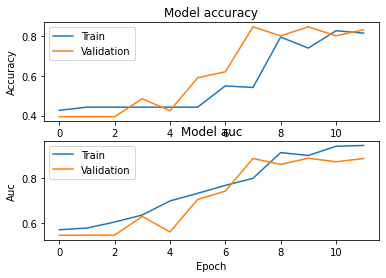

In [27]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc_3'])
ax2.plot(history.history['val_auc_3'])
ax2.set_title('Model auc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Auc')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.show()

AUC stands for "Area Under Curve" and is the measure of the ability of a classifier to distinguish between classes. This means that the model has over 80% chance of classifying an X-ray correctly. 

The accuracy says how likely it is that the model will assign the highest probability to the correct class more than 80% of the time

In [29]:
print(f"The AUC of the model is {history.history['val_auc_3'][-1]}")
print(f"The categorical accuracy of the model is {history.history['val_categorical_accuracy'][-1]}")

The AUC of the model is 0.8851010799407959
The categorical accuracy of the model is 0.8333333134651184
